In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
data = pd.read_csv("data_2002_2024.csv")
data

,team,season,week,total_yards,def_yards_allowed,turnovers,possession_time,pass_yards,rush_yards,third_down_pct,redzone_pct,point_diff,ypp,result,is_champion
0,49ers,2002,17,329,263,2,2137,136,193,0.428571,0.000000,-11,5.222222,0,0
1,49ers,2002,16,358,184,2,2059,252,106,0.550000,0.000000,3,4.904110,1,0
2,49ers,2002,15,263,302,1,1437,156,107,0.461538,0.000000,-6,4.614035,0,0
3,49ers,2002,14,401,257,1,2159,276,125,0.500000,0.000000,4,4.717647,1,0
4,49ers,2002,13,299,507,2,1945,157,142,0.562500,0.000000,7,4.397059,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7355,Vikings,2024,13,273,406,1,1451,205,68,0.125000,0.500000,1,5.352941,1,0
7356,Vikings,2024,12,452,398,1,2006,328,124,0.461538,0.428571,3,6.953846,1,0
7357,Vikings,2024,11,318,294,1,1951,236,82,0.357143,1.000000,10,4.746269,1,0
7358,Vikings,2024,10,402,143,3,2539,233,169,0.357143,0.000000,5,4.902439,1,0


In [3]:
# Load dicts
with open("playoff_dict.json") as f:
    playoff_dict = json.load(f)
playoff_dict = {int(k): v for k, v in playoff_dict.items()}

with open("finalists_dict.json") as f:
    finalists_dict = json.load(f)
finalists_dict = {int(k): v for k, v in finalists_dict.items()}

with open("champions_dict.json") as f:
    champions_dict = json.load(f)
champions_dict = {int(k): v for k, v in champions_dict.items()}

with open("division_winners_dict.json") as f:
    division_winners_dict = json.load(f)
division_winners_dict = {int(k): v for k, v in division_winners_dict.items()}

In [4]:
# Function to get training data
def get_training_data(data, season, year_back, playoff_dict, top_seed_dict, champions_dict):
    # Select data from past seasons within the training window size
    train = data[(data["season"] < season) & (data["season"] >= (season - year_back))]

    # Filter for playoff teams who are either top seeds or previous champions
    train = train[
        train.apply(lambda row: (
            (row["team"] in playoff_dict.get(row["season"], [])) and
            (
                (row["team"] in top_seed_dict.get(row["season"], [])) or 
                (row["team"] == champions_dict.get(row["season"], -1))
            )
        ), axis=1)
    ]

    # Separate features (X) and labels (y)
    X_train = train.drop(columns=["team", "season", "week", "result", "is_champion"])
    y_train = train["is_champion"]
    
    return X_train, y_train


# Function to train an XGBoost model
def train_model(X_train, y_train):
    # Initialise model
    model = XGBClassifier(eval_metric="logloss", random_state=42)

    # Train model
    model.fit(X_train, y_train)
    
    return model


# Function to get season data for prediction
def get_season_data(data, season, playoff_dict):
    # Select data for the target season
    season_data = data[data["season"] == season]

    # Filter for playoff teams
    season_data = season_data[season_data.apply(lambda row: row["team"] in playoff_dict.get(row["season"], []), axis=1)]
    
    # Keep only the last 4 weeks of the season
    season_data = season_data[season_data["week"] >= season_data["week"].max() - 3]
    
    return season_data.reset_index(drop=True)


# Function to predict, rank, and evaluate predictions for a season
def predict_and_evaluate(model, season_data, season, year):
    # Prepare features for prediction
    X_season = season_data.drop(columns=["team", "season", "week", "result", "is_champion"])

    # Predict championship probabilities
    probs = model.predict_proba(X_season)[:, 1]

    # Prepare ranking dataframe
    ranked = season_data[["team"]].copy()
    ranked["prob"] = probs

    # Assign weight to each week (to give more importance to recent games)
    ranked["weight"] = (season_data["week"] - season_data["week"].min() + 1) ** 1.4
    ranked["is_champion"] = season_data["is_champion"]

    # Average probabilities per team using weighted average
    ranked = ranked.groupby(["team", "is_champion"]).apply(
        lambda df: np.average(df["prob"], weights=df["weight"])
    ).reset_index().rename(columns={0: "prob"})

    # Sort teams by predicted probability
    ranked = ranked.sort_values("prob", ascending=False).reset_index(drop=True)

    # Create y_true and y_pred for probabilistic metrics
    y_true = (ranked["is_champion"] == 1).astype(int).tolist()
    y_pred = ranked["prob"].tolist()

    # Calculate total probability for normalisation
    total_prob = ranked["prob"].sum()
    
    return {
        "superbowl_year": season,
        "n_seasons_history": year,
        "model_pick_team": ranked.iloc[0]["team"],
        "model_pick_prob": ranked.iloc[0]["prob"] / total_prob,
        "is_prediction_correct": ranked.iloc[0]["is_champion"] == 1,
        "is_champion_in_top2": (ranked[ranked["is_champion"] == 1].index[0] + 1) <= 2,
        "is_champion_in_top7": (ranked[ranked["is_champion"] == 1].index[0] + 1) <= 7,
        "champion_team": ranked[ranked["is_champion"] == 1]["team"].iloc[0],
        "true_prob": ranked[ranked["is_champion"] == 1]["prob"].iloc[0] / total_prob,
        "y_true": y_true,
        "y_pred": [p / total_prob for p in y_pred],
        "team_names": ranked["team"].tolist()
    }


# Main function to evaluate model over multiple historical periods and seasons
def evaluate_all_year_backs(data, playoff_dict, top_seed_dict, champions_dict):
    all_results = []
    trained_models = {}

    # Loop through each history window
    for year_back in [1, 2, 3, 4, 7, 10, 12]:
        results = []

        # Evaluate for each season
        for season in range(2019,2025):
            # Get training data
            X_train, y_train = get_training_data(data, season, year_back, playoff_dict, top_seed_dict, champions_dict)

            # Train model
            model = train_model(X_train, y_train)
            trained_models[(year_back, season)] = model

            # Prepare test data and evaluate
            season_data = get_season_data(data, season, playoff_dict)
            result = predict_and_evaluate(model, season_data, season, year_back)
            results.append(result)

        # Append season results to overall results
        all_results.extend(results)

    return pd.DataFrame(all_results), trained_models

all_results, all_models = evaluate_all_year_backs(
    data, playoff_dict, division_winners_dict, champions_dict
)

In [5]:
# Calculate metrics for a single window size
def calculate_metrics_for_group(group):
    # Extract list of y_true and y_pred lists for all seasons
    y_trues = group["y_true"].tolist()
    y_preds = group["y_pred"].tolist()

    # Flatten nested lists into single lists
    y_true = [item for sublist in y_trues for item in sublist]
    y_pred = [item for sublist in y_preds for item in sublist]

    # Return all metrics as a pandas Series
    return pd.Series({
        "Top 1 Accuracy": group["is_prediction_correct"].mean(),
        "Top 2 Accuracy": group["is_champion_in_top2"].mean(),
        "Top 7 Accuracy": group["is_champion_in_top7"].mean(),
        "Weighted Contender Score (WCS)": group["is_prediction_correct"].mean() * 0.45 +
                                          group["is_champion_in_top2"].mean() * 0.35 +
                                          group["is_champion_in_top7"].mean() * 0.2,
        "AUC": roc_auc_score(y_true, y_pred),
        "LogLoss": log_loss(y_true, y_pred, labels=[0, 1]),
        "Brier Score": brier_score_loss(y_true, y_pred)
    })


# Compute probabilistic metrics for all window sizes
def compute_probabilistic_metrics(all_results):
    # Group by window size (n_seasons_history) and apply metrics function
    metrics_df = all_results.groupby("n_seasons_history").apply(
        calculate_metrics_for_group
    ).reset_index()

    # Rename column for clarity
    metrics_df.rename(columns={"n_seasons_history": "Window Size"}, inplace=True)
    
    return metrics_df

metrics_df = compute_probabilistic_metrics(all_results)
metrics_df.round(4)

,Window Size,Top 1 Accuracy,Top 2 Accuracy,Top 7 Accuracy,Weighted Contender Score (WCS),AUC,LogLoss,Brier Score
0,1,0.1667,0.1667,0.8333,0.3000,0.7390,0.2497,0.0697
1,2,0.1667,0.5000,1.0000,0.4500,0.8136,0.2166,0.0612
2,3,0.3333,0.5000,0.8333,0.4917,0.7544,0.2378,0.0652
3,4,0.0000,0.1667,1.0000,0.2583,0.7390,0.2402,0.0682
4,7,0.1667,0.3333,0.6667,0.3250,0.6031,0.2806,0.0685
5,10,0.0000,0.3333,0.6667,0.2500,0.6930,0.2581,0.0664
6,12,0.1667,0.3333,0.8333,0.3583,0.6535,0.2465,0.0651


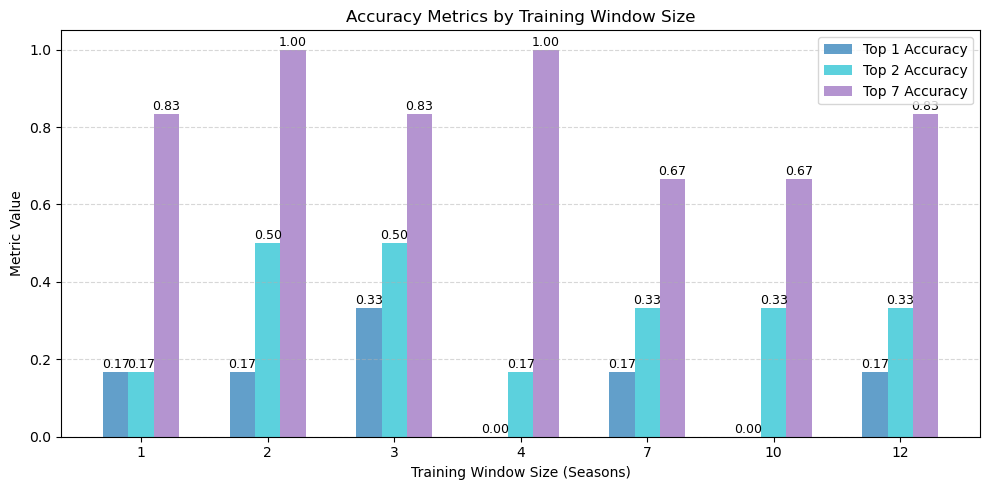

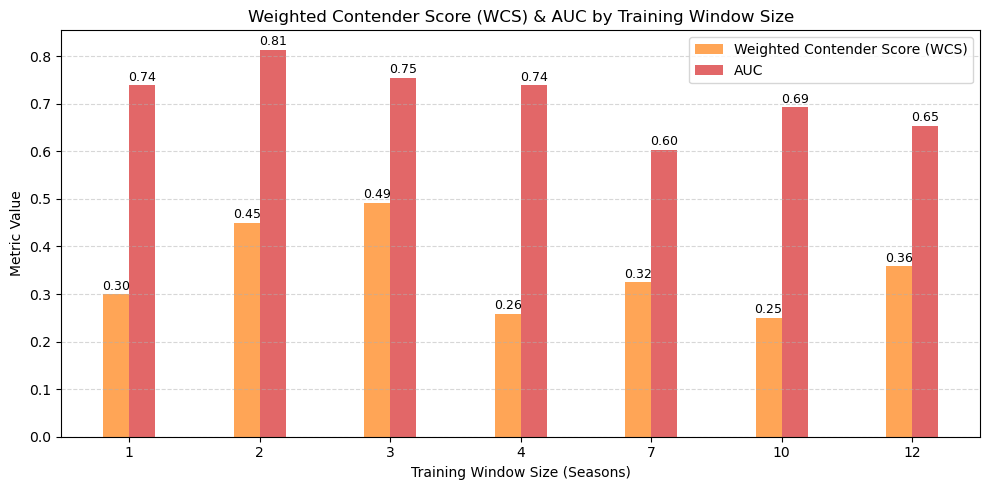

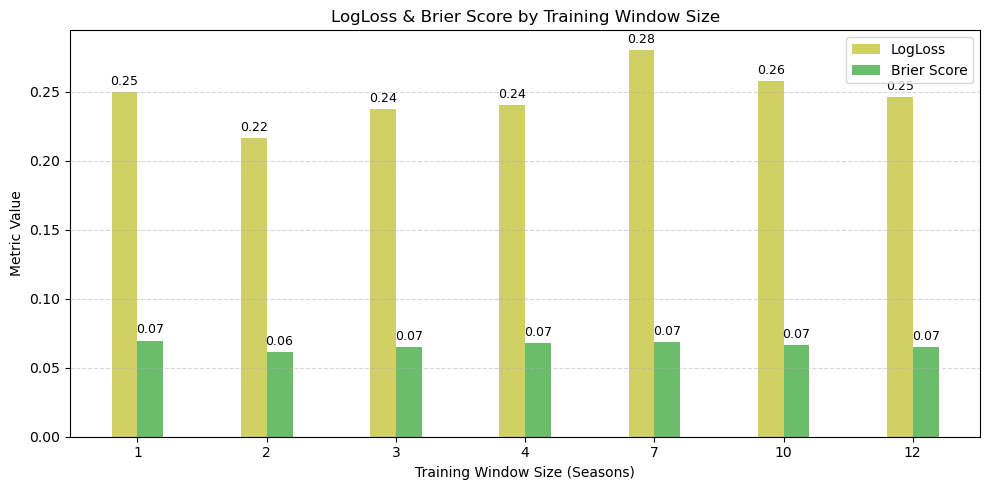

In [6]:
# Plots grouped bar charts to compare performance metrics across training window sizes
def plot_metric_group(metrics_df, metrics, title, bar_width=0.2):
    # Define color mapping for each metric
    colors = {
        "Top 1 Accuracy": 'tab:blue',
        "Top 2 Accuracy": 'tab:cyan',
        "Top 7 Accuracy": 'tab:purple',
        "Weighted Contender Score (WCS)": 'tab:orange',
        "AUC": 'tab:red',
        "LogLoss": 'tab:olive',
        "Brier Score": 'tab:green'
    }

    # Extract window sizes and setup x-axis positions
    windows = metrics_df['Window Size']
    x = np.arange(len(windows))

    # Plot bars for each selected metric
    plt.figure(figsize=(10, 5))
    for i, metric in enumerate(metrics):
        offset = i * bar_width
        bar_x = x + offset
        values = metrics_df[metric]
        plt.bar(bar_x, values, width=bar_width, label=metric, color=colors[metric], alpha=0.7)

        # Add value labels above each bar
        for x_pos, val in zip(bar_x, values):
            plt.text(x_pos, val + 0.003, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

    # Axis and grid settings
    plt.xticks(x + bar_width * (len(metrics) - 1) / 2, windows)
    plt.title(title)
    plt.xlabel("Training Window Size (Seasons)")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_metric_group(metrics_df, ["Top 1 Accuracy", "Top 2 Accuracy", "Top 7 Accuracy"], "Accuracy Metrics by Training Window Size")
plot_metric_group(metrics_df, ["Weighted Contender Score (WCS)", "AUC"], "Weighted Contender Score (WCS) & AUC by Training Window Size")
plot_metric_group(metrics_df, ["LogLoss", "Brier Score"], "LogLoss & Brier Score by Training Window Size")

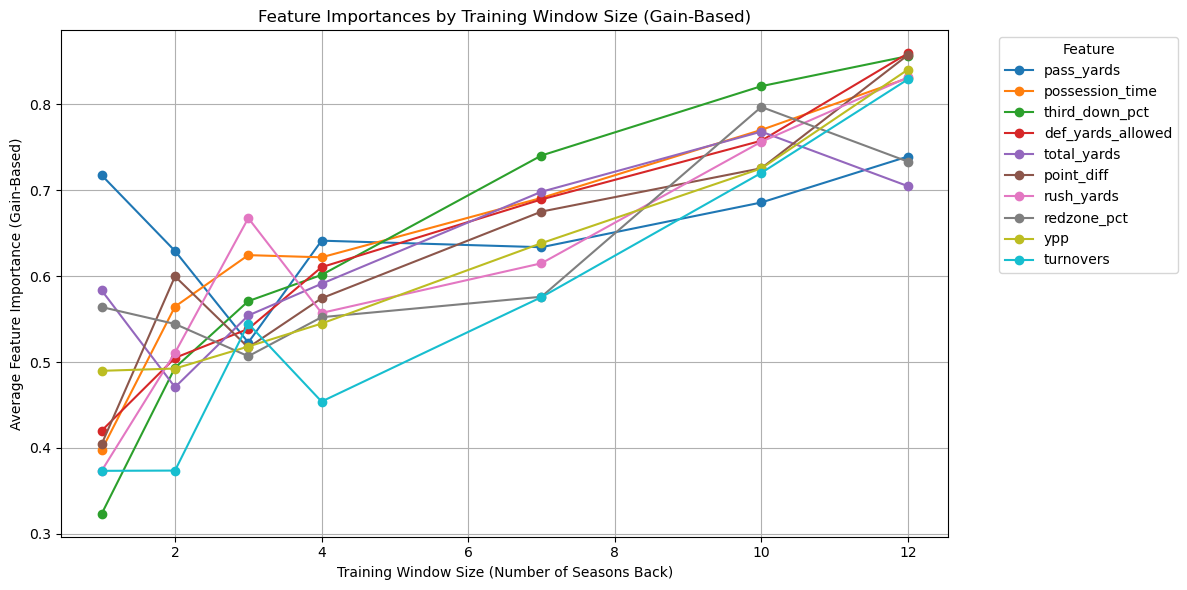

In [7]:
# Plots the average feature importances of XGBoost models across different training window sizes
def plot_feature_importances(models):
    # List of feature names used in the models
    feature_names = ["total_yards", "def_yards_allowed", "turnovers", "possession_time", "pass_yards", "rush_yards", "third_down_pct", "redzone_pct", "point_diff", "ypp"]

    # Collect feature importances from each model
    rows = []
    for (year_back, season), model in models.items():
        booster = model.get_booster()
        # Get feature importances based on 'gain'
        score_dict = booster.get_score(importance_type='gain')

        # Build row: include 0.0 for features not used in splits
        row = {"year_back": year_back}
        for f in feature_names:
            row[f] = score_dict.get(f, 0.0)
        rows.append(row)

    # Create DataFrame from all rows
    df = pd.DataFrame(rows)

    # Calculate average feature importance per training window size
    avg_df = df.groupby("year_back").mean(numeric_only=True)

    # Sort features by overall average importance (descending)
    mean_importance = avg_df.mean(axis=0).sort_values(ascending=False)
    avg_df = avg_df[mean_importance.index]

    # Plot feature importances as line plots
    plt.figure(figsize=(12, 6))
    for feature in avg_df.columns:
        plt.plot(avg_df.index, avg_df[feature], marker='o', label=feature)

    # Plot formatting
    plt.title("Feature Importances by Training Window Size (Gain-Based)")
    plt.xlabel("Training Window Size (Number of Seasons Back)")
    plt.ylabel("Average Feature Importance (Gain-Based)")
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_feature_importances(all_models)

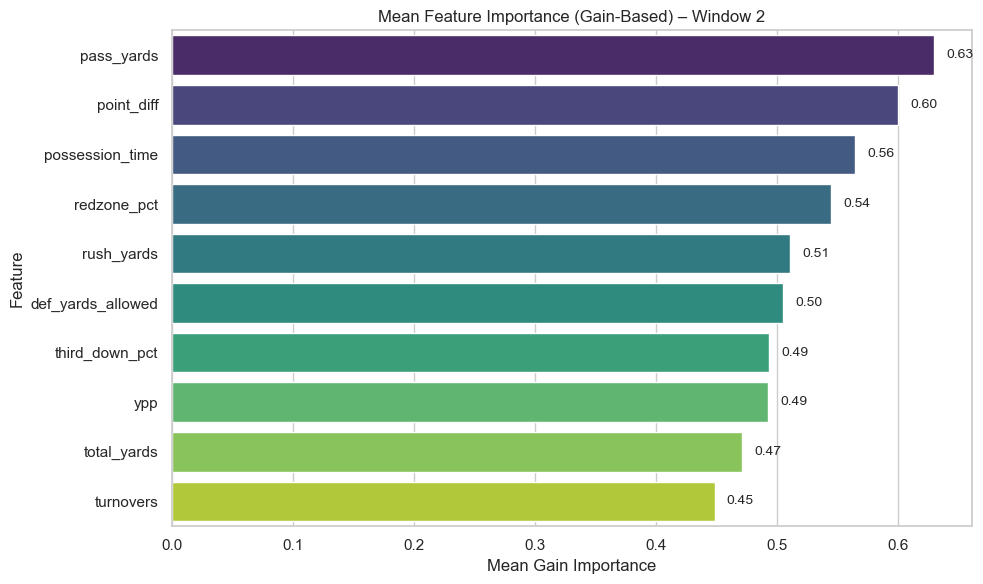

In [8]:
# Plots the mean feature importance for all models trained with a specific window size
def plot_window_feature_importance(models, window):

    # Collect feature importances for the specified window
    rows = []
    for (year_back, season), model in models.items():
        if year_back != window:
            continue
        booster = model.get_booster()
        importance_dict = booster.get_score(importance_type='gain')

        # Store feature importances
        for feature_name, importance in importance_dict.items():
            rows.append({
                'window': window,
                'season': season,
                'feature': feature_name,
                'importance': importance
            })

    # Create DataFrame of importances
    df = pd.DataFrame(rows)

    # Calculate mean importance per feature
    mean_imp = (df.groupby('feature')['importance'].mean().sort_values(ascending=False))

    # Plot barplot
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("viridis", len(mean_imp))
    sns.set(style="whitegrid")
    ax = sns.barplot(x=mean_imp.values, y=mean_imp.index, palette=colors)

    # Add value labels
    for i, (val, label) in enumerate(zip(mean_imp.values, mean_imp.index)):
        ax.text(val + 0.01, i, f"{val:.2f}", va='center', fontsize=10)

    plt.title(f'Mean Feature Importance (Gain-Based) – Window {window}')
    plt.xlabel('Mean Gain Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_window_feature_importance(all_models, window=2)

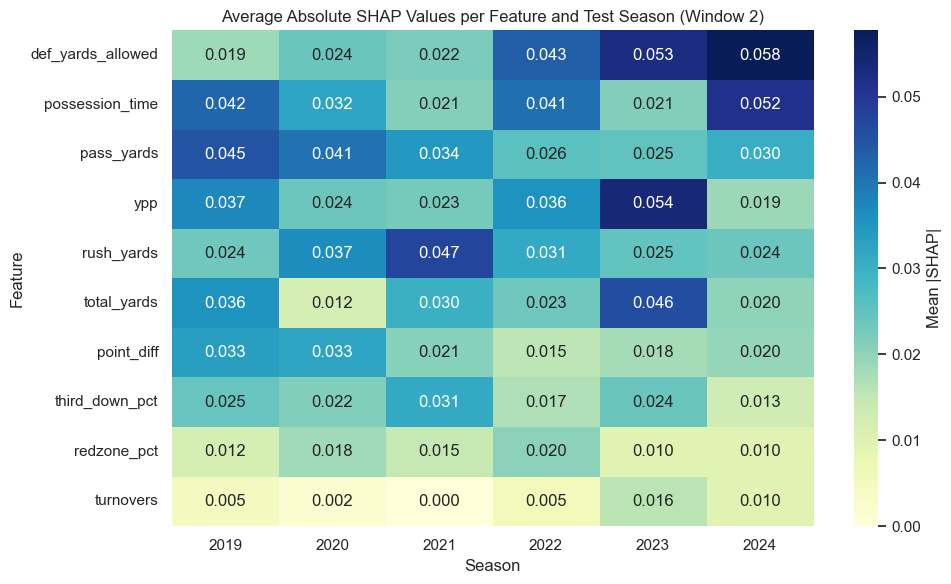

In [9]:
def plot_shap_heatmap(models, data, playoff_dict, division_winners_dict, champions_dict, window):
    
    rows = []
    
    # Get list of seasons that were evaluated with the selected window size
    seasons_for_window = [season for (w, season) in models if w == window]

    # Loop over each season
    for season in seasons_for_window:
        # Retrieve the model for this specific window and season
        model = models[(window, season)]
        
        # Get the training data used for this season
        X_train, y_train = get_training_data(data, season, window, playoff_dict, division_winners_dict, champions_dict)

        # Create SHAP explainer for the model
        explainer = shap.Explainer(model, X_train, model_output="probability")
        # Compute SHAP values for all training samples
        shap_values = explainer(X_train)

        # Compute mean absolute SHAP values for each feature across all samples
        shap_array = np.abs(shap_values.values).mean(axis=0)
        feature_names = X_train.columns

        # Store feature importance data for this season
        for feature, value in zip(feature_names, shap_array):
            rows.append({
                'season': season,
                'feature': feature,
                'mean_abs_shap': value
            })

    # Create dataframe from results
    df_shap = pd.DataFrame(rows)

    # Create pivot table: features x seasons
    shap_matrix = df_shap.pivot(index='season', columns='feature', values='mean_abs_shap').fillna(0)

    # Sort features by overall mean importance
    sorted_features = shap_matrix.mean().sort_values(ascending=False).index
    shap_matrix = shap_matrix[sorted_features]

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(shap_matrix.T, annot=True, fmt=".3f", cmap='YlGnBu', cbar_kws={'label': 'Mean |SHAP|'})
    plt.title(f'Average Absolute SHAP Values per Feature and Test Season (Window {window})')
    plt.xlabel('Season')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return shap_matrix
    
shap_df = plot_shap_heatmap(all_models, data, playoff_dict, division_winners_dict, champions_dict, window=2)

### Export Results and Model for Case Study 2024

This optional cell exports the full prediction results and the trained model for window size = 2 in season 2024.  
The exported results are used later in the case study notebook to analyse the 2024 season predictions.

In [11]:
# OPTIONAL: Uncomment to export results
if False:
    # Save prediction results
    all_results.to_csv("scenario2_predictions.csv")

    # Save trained model for window size = 2, season = 2024
    model = all_models[(2, 2024)]
    model.save_model("model_scenario2_2024_window2.json")